In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from LAb_UW_functions import *
from scipy.signal import find_peaks
import os
import glob

In [21]:

def find_mechanical_data(file_path_list, pattern):
    """
    Trova un file specifico all'interno di una lista di percorsi dei file utilizzando un pattern.
    
    Args:
        file_path_list (list): Lista di percorsi dei file in cui cercare il file.
        pattern (str): Pattern per il nome del file da cercare.
    
    Returns:
        str: Percorso completo del file trovato, o None se non viene trovato nessun file corrispondente.
    """
    for file_path in file_path_list:
        if glob.fnmatch.fnmatch(file_path, pattern):
            print("mechanical data:", file_path)
            return file_path
    return None  # Nessun file trovato nella lista
    

def find_sync_values(mech_data_path):
    """
    Trova i valori di picco sincronizzazione all'interno di un file di dati meccanici.

    Questa funzione legge un file CSV contenente dati meccanici, estrae la colonna
    relativa alla sincronizzazione e individua i picchi di sincronizzazione in base
    ai parametri specificati.

    Args:
        mech_data_path (str): Percorso del file CSV contenente i dati meccanici.

    Returns:
        numpy.ndarray: Un array NumPy contenente gli indici dei picchi di sincronizzazione
                       trovati nei dati meccanici.
    """
    mech_data = pd.read_csv(mech_data_path, sep=',', skiprows=[1])
    sync_data = mech_data.sync
    
    # Trova i picchi di sincronizzazione nei dati sincronizzazione
    sync_peaks, _ = find_peaks(sync_data, prominence=4.2, height=4)
    print(sync_peaks)
    return mech_data, sync_data, sync_peaks

def plot_sync_peaks(sync_data, sync_peaks, experiment_name):
    """
    Visualizza i picchi di sincronizzazione su un grafico dei dati di sincronizzazione.

    Questa funzione prende i dati di sincronizzazione e gli indici dei picchi di sincronizzazione,
    quindi crea un grafico per visualizzare sia i dati di sincronizzazione che i picchi di sincronizzazione
    evidenziati in rosso.

    Args:
        sync_data (numpy.ndarray): Array NumPy contenente i dati di sincronizzazione.
        sync_peaks (numpy.ndarray): Array NumPy contenente gli indici dei picchi di sincronizzazione.
        experiment_name (str): Nome dell'esperimento o della prova da visualizzare nel titolo del grafico.
    """
    %matplotlib inline
    
    plt.figure(figsize=(10, 4))
    plt.title(f'Sync Peaks {experiment_name}')
    

    # Plot dei picchi di sincronizzazione evidenziati in rosso
    plt.scatter(np.arange(0, len(sync_data))[sync_peaks], sync_data[sync_peaks], c='r', s = 10, zorder = 2, alpha = 0.8)
    
    # Plot dei dati di sincronizzazione
    plt.plot(sync_data, zorder = 1, c = 'k', linewidth = 0.8)
    
    plt.ylabel('Arduino voltage [V]', fontsize=12)
    plt.xlabel('records #', fontsize=12)
    
    plt.show()
    

def save_sync_values(machine_name, experiment_name, data_type, sync_peaks):
    """
    Save synchronization peak values into a text file.

    This function takes synchronization peak values and saves them into a text file
    specified in the experiments directory.

    Args:
        machine_name (str): Name of the machine or device.
        experiment_name (str): Name of the experiment or trial.
        data_type (str): Type of data (e.g., "mechanical_data").
        sync_peaks (numpy.ndarray): NumPy array containing the indices of synchronization peaks.
    """
    code_path = os.getcwd()
    parent_folder = os.path.abspath(os.path.join(code_path, os.pardir))
    outdir_path = os.path.join(parent_folder, "experiments_" + machine_name, experiment_name, data_type)
    outfile_name = 'sync_peaks.txt'
    outfile_path = os.path.join(outdir_path, outfile_name)
    
    # Save synchronization peak values into the text file
    np.savetxt(outfile_path, sync_peaks)
    
    # Print a confirmation message
    print(f'Saving synchronization peaks of {experiment_name} at: {outfile_path}')


mechanical data: c:\Users\miche\Documents\Università\PhD\ACTIVE_SOURCE\experiments_Brava_2\s0103\mechanical_data\s0103sw06mont1020_data_rp
[  4833   8929  10846  19949  21747  25821  31188  65233  74894 118942
 154601 156625 161550 167109 168462 173290 174740 212394 226240 264730
 297994 392907 411811 462252]


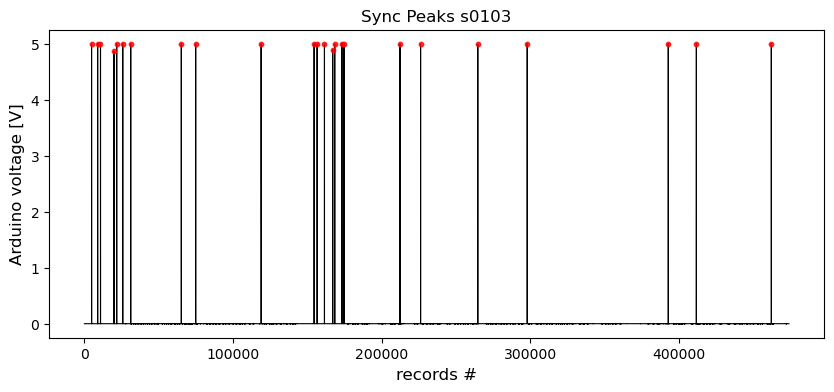

In [22]:
# Utilizzo dell'approccio per trovare un file specifico
machine_name = 'Brava_2'
experiment_name = 's0103'
data_type_mech = 'mechanical_data'
sync_file_pattern = '*s*_data_rp'

data_type_uw = 'data_tsv_files'
remove_initial_samples = 50

infile_path_list_mech = make_infile_path_list(machine_name, experiment_name, data_type=data_type_mech)
infile_path_list_uw = make_infile_path_list(machine_name,experiment_name, data_type=data_type_uw)
infile_path_list_uw.sort()


mech_data_path= find_mechanical_data(infile_path_list_mech, sync_file_pattern)
    
mech_data, sync_data, sync_peaks = find_sync_values(mech_data_path)
plot_sync_peaks(sync_data, sync_peaks, experiment_name)

In [ ]:
for sync_rec, uw_path in zip(range (0, len(sync_peaks), 2), infile_path_list_uw):    
    friction = mech_data.friction_na[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
    time = mech_data.time_s[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
    time = time - time[sync_peaks[sync_rec]]
    displacement = mech_data.lp_disp_mm[sync_peaks[sync_rec]:sync_peaks[sync_rec+1]]
    
    uw_data, uw_metadata = make_UW_data(uw_path)
    uw_data, uw_metadata = remove_starting_noise(uw_data,uw_metadata,remove_initial_samples=remove_initial_samples)
    
    print(uw_path)
    
    ptp_giusta = []
    for uw in range (0,len(uw_data)):

        massimo = np.max(uw_data[uw])
        minimo = np.min(uw_data[uw][:np.argmax(uw_data[uw])])
        ptp_giusta.append(massimo-minimo)

    ptp_giusta = np.array(ptp_giusta)
    
    f = plt.figure(figsize = (12,8))
    plt.plot(time,friction)
    plt.twinx()
    plt.plot(ptp_giusta, c= 'r', linewidth = 0.6, alpha = 0.8)


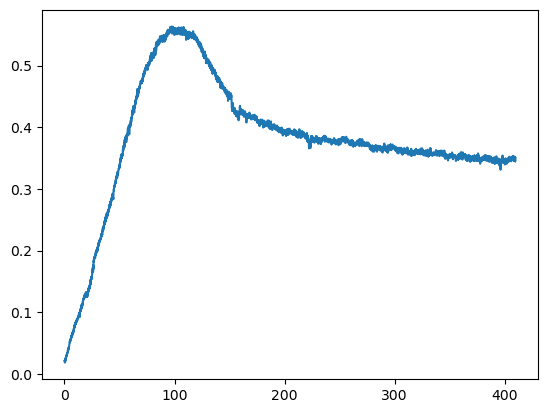

In [7]:
plt.plot(time, friction)